In [1]:
!pip install timm

In [2]:
import pandas as pd
import numpy as np
import cv2
import math
import timm
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

In [5]:
data_dir = '/kaggle/input/self-driving-cars/images/'
input_size = 512

In [6]:
train_df = pd.read_csv("/kaggle/input/self-driving-cars/labels_trainval.csv")
def get_data(x):
    filename = data_dir + x["frame"]              
    img = cv2.imread(filename)
    height, width, channels = img.shape
    x_scale = input_size / width
    y_scale = input_size / height
    try:
        xmin = int(np.round(float(x["xmin"]) * x_scale))
        ymin = int(np.round(float(x["ymin"]) * y_scale))
        w = int(np.round(float(x["xmax"]-x["xmin"]) * x_scale))
        h = int(np.round(float(x["ymax"]-x["ymin"]) * y_scale))
        bbox = [xmin, ymin, w, h]
    except:
        bbox = [-1, -1, -1, -1]
    return [x["frame"],input_size,input_size,x["class_id"]-1,bbox[0],bbox[1],bbox[2],bbox[3]]
train_df['image_id'] = -1
train_df['width'] = -1
train_df['height'] = -1
train_df['bbox'] = -1
train_df['class'] = -1
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

train_df[['image_id','width','height','class','x', 'y', 'w', 'h']] = np.stack(train_df.apply(lambda x: get_data(x),axis=1))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float64)
train_df['y'] = train_df['y'].astype(np.float64)
train_df['w'] = train_df['w'].astype(np.float64)
train_df['h'] = train_df['h'].astype(np.float64)

In [7]:
train_df.head()

,frame,xmin,xmax,ymin,ymax,class_id,image_id,width,height,class,x,y,w,h
0,1478019952686311006.jpg,237,251,143,155,1,1478019952686311006.jpg,512,512,0,253.0,244.0,15.0,20.0
1,1478019952686311006.jpg,437,454,120,186,3,1478019952686311006.jpg,512,512,2,466.0,205.0,18.0,113.0
2,1478019953180167674.jpg,218,231,146,158,1,1478019953180167674.jpg,512,512,0,233.0,249.0,14.0,20.0
3,1478019953689774621.jpg,171,182,141,154,2,1478019953689774621.jpg,512,512,1,182.0,241.0,12.0,22.0
4,1478019953689774621.jpg,179,191,144,155,1,1478019953689774621.jpg,512,512,0,191.0,246.0,13.0,19.0


In [8]:
train_df = train_df.drop(['frame', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], axis=1)
train_df.head()

,image_id,width,height,class,x,y,w,h
0,1478019952686311006.jpg,512,512,0,253.0,244.0,15.0,20.0
1,1478019952686311006.jpg,512,512,2,466.0,205.0,18.0,113.0
2,1478019953180167674.jpg,512,512,0,233.0,249.0,14.0,20.0
3,1478019953689774621.jpg,512,512,1,182.0,241.0,12.0,22.0
4,1478019953689774621.jpg,512,512,0,191.0,246.0,13.0,19.0


In [9]:
train_df.to_csv("ProcessedData-2.csv")

In [10]:
train_df = pd.read_csv("/kaggle/working/ProcessedData-2.csv")

In [11]:
# Hyper-params
MODEL_PATH = "/kaggle/input/centernetmodels-pretrained/centernet_state_dict3.pth"
input_size = 512
IN_SCALE = 512//input_size 
MODEL_SCALE = 2
batch_size = 252
model_name = "resnet18"
TRAIN = True
n_classes = len(np.unique(train_df["class"]))
gaussian_iou = 0.5
max_objs = 100

In [12]:
from sklearn.model_selection import train_test_split
image_ids = train_df['image_id'].unique()
train_id, test_id = train_test_split(image_ids, test_size=0.20, random_state=777)

In [13]:
# get targets
target = train_df[train_df['image_id']==train_id[55]]
img = cv2.imread(data_dir+train_id[55])
img = cv2.resize(img,(input_size,input_size))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# convert targets to its center.
try:
    center = np.array([target["x"]+target["w"]//2, target["y"]+target["h"]//2]).T
except:
    center = np.array([int(target["x"]+target["w"]//2), int(target["y"]+target["h"]//2)]).T.reshape(1,2)

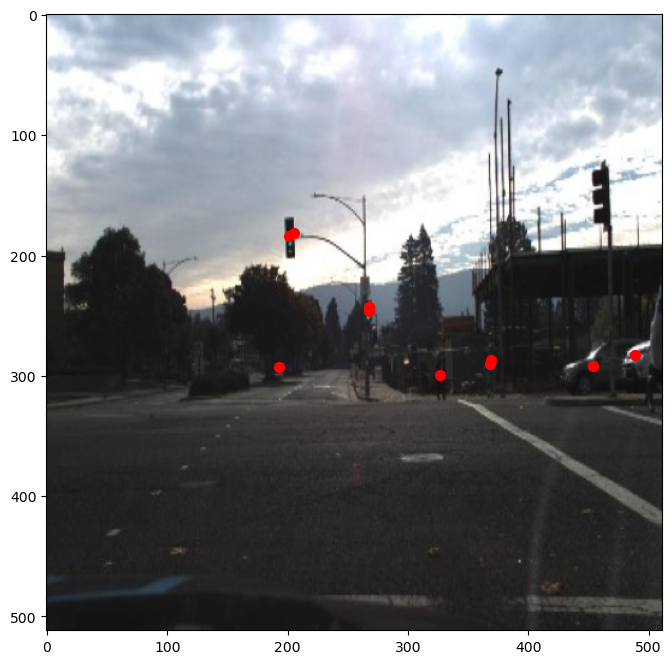

In [14]:
# plot centers on image
plt.figure(figsize=(8,8))
plt.imshow(img)
for x in center:
    plt.scatter(x[0], x[1], color='red', s=50)

In [15]:
def _gather_feature(feat, ind, mask=None):
    dim = feat.size(2)
    ind = ind.unsqueeze(2).expand(ind.size(0), ind.size(1), dim)
    feat = feat.gather(1, ind)
    if mask is not None:
        mask = mask.unsqueeze(2).expand_as(feat)
        feat = feat[mask]
        feat = feat.view(-1, dim)
    return feat

def _tranpose_and_gather_feature(feat, ind):
    feat = feat.permute(0, 2, 3, 1).contiguous()
    feat = feat.view(feat.size(0), -1, feat.size(3))
    feat = _gather_feature(feat, ind)
    return feat

def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def gaussian_radius(det_size, min_overlap=0.7):
    height, width = det_size
    a1 = 1
    b1 = (height + width)
    c1 = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1 = (b1 - sq1) / (2 * a1)

    a2 = 4
    b2 = 2 * (height + width)
    c2 = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2 = (b2 - sq2) / (2 * a2)

    a3 = 4 * min_overlap
    b3 = -2 * min_overlap * (height + width)
    c3 = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3 = (b3 + sq3) / 2
    return min(r1, r2, r3)

def draw_umich_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0:  # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap

In [16]:
# Wrapped heatmap function
def make_hm_regr(target,num_classes = 5,input_size_x = 512,input_size_y = 512,MODEL_SCALE=2,max_objs=100,gaussian_iou = 0.7):
    hmap = np.zeros((num_classes, input_size_y//MODEL_SCALE, input_size_x//MODEL_SCALE), dtype=np.float32)
    w_h_ = np.zeros((max_objs, 2), dtype=np.float32)
    regs = np.zeros((max_objs, 2), dtype=np.float32)
    inds = np.zeros((max_objs,), dtype=np.int64)
    ind_masks = np.zeros((max_objs,), dtype=np.uint8)
    try:
        boxes = np.array([target["x"]+target["w"]//2, target["y"]+target["h"]//2, 
                       target["w"], target["h"]
                      ]).T
    except:
        boxes = np.array([int(target["x"]+target["w"]//2), int(target["y"]+target["h"]//2), 
                       int(target["w"]), int(target["h"])
                      ]).T.reshape(1,4)
    classes = list(target["class"])
    for i,box in enumerate(boxes):
        if (box[0]>512) or (box[1]>512):
            continue
        center = np.array([(box[0]),(box[1])], dtype=np.float32)
        obj_c = np.array([(box[0]//MODEL_SCALE),(box[1]//MODEL_SCALE)], dtype=np.float32)
        obj_c_int = obj_c.astype(np.int32)
        h = box[3]
        w = box[2]
        if h > 0 and w > 0:
            radius = max(0, int(gaussian_radius((math.ceil(h), math.ceil(w)), gaussian_iou)))
            hmap[int(classes[i]),:,:] = draw_umich_gaussian(hmap[int(classes[i]),:,:], obj_c_int, radius)   
            w_h_[i] =  w/input_size_x, h/input_size_y
            regs[i] = center - (obj_c_int*MODEL_SCALE)
            inds[i] = ((obj_c_int[1]) * (input_size_x//MODEL_SCALE)) + (obj_c_int[0])
            ind_masks[i] = 1
    return {'hmap': hmap, 'w_h_': w_h_, 'regs': regs, 'inds': inds, 'ind_masks': ind_masks}

In [17]:
def showbox(img, hm, wh, regr,box_=None):
    sample = cv2.resize(img, (input_size,input_size))
    boxes = ctdet_decode(hm,wh,regr)
    font = cv2.FONT_HERSHEY_SIMPLEX
    color =(250, 0, 0)
    for box in boxes:
        cv2.rectangle(sample,
                      (int(box[0]-(box[2]/2)), int(box[1]-(box[3]/2))),
                      (int(box[0]+(box[2]/2)), int(box[1]+(box[3]/2))),
                      color, 2)
        cv2.putText(sample,"Class-{}".format(box[-1]),(int(box[0]-(box[2]/2)), int(box[1]-(box[3]/2))-10),font,0.35,color,2) 
    return sample

def _nms(heat, kernel=7):
    hmax = F.max_pool2d(heat, kernel, stride=1, padding=(kernel - 1) // 2)
    keep = (hmax == heat).float()
    return heat * keep


def _topk(scores, K=40, threshold=0.2):
    batch, cat, height, width = scores.size()

    topk_scores, topk_inds = torch.topk(scores.view(batch, cat, -1), K)
    topk_inds = topk_inds % (height * width)
    topk_ys = (topk_inds / width).int().float()
    topk_xs = (topk_inds % width).int().float()

    topk_score, topk_ind = torch.topk(topk_scores.view(batch, -1), K)
    topk_clses = (topk_ind / K).int()
    topk_inds = _gather_feature(topk_inds.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_ys = _gather_feature(topk_ys.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_xs = _gather_feature(topk_xs.view(batch, -1, 1), topk_ind).view(batch, K)
    ttrue = torch.ones(topk_score.shape, dtype=torch.bool).to(topk_score.device)
    ffalse = torch.zeros(topk_score.shape, dtype=torch.bool).to(topk_score.device)
    mask = torch.where(topk_score>threshold, ttrue, ffalse)
    return topk_score[:,mask[0]], topk_inds[:,mask[0]], topk_clses[:,mask[0]], topk_ys[:,mask[0]], topk_xs[:,mask[0]], len(topk_score[:,mask[0]][0])


def ctdet_decode(hmap, w_h_, regs, K=40):
    batch, cat, height, width = hmap.shape
    batch = 1
    input_size_x = 512
    input_size_y = 512
    hmap = _nms(hmap)  # perform nms on heatmaps

    scores, inds, clses, ys, xs, M = _topk(hmap, K=K)
    regs = _tranpose_and_gather_feature(regs, inds)
    regs = regs.view(batch, M, 2)
    xs = xs.view(batch, M, 1)*MODEL_SCALE + regs[:, :, 0:1]
    ys = ys.view(batch, M, 1)*MODEL_SCALE + regs[:, :, 1:2]
    w_h_ = _tranpose_and_gather_feature(w_h_, inds)
    w_h_ = w_h_.view(batch, M, 2)

    clses = clses.view(batch, M, 1).float()
    scores = scores.view(batch, M, 1)
    bboxes = torch.cat([xs ,ys  ,w_h_[..., 0:1]*input_size_x ,w_h_[..., 1:2]*input_size_y ], dim=2)
    detections = torch.cat([bboxes, scores, clses], dim=2)
    return detections.cpu().numpy()[0]

In [18]:
from torchvision import transforms

class CarDataset(torch.utils.data.Dataset):
    def __init__(self, image_ids, data):
        self.image_ids = image_ids
        self.dataset = data
        self.preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
    def __len__(self):
        return len(self.image_ids)

    def __getitem_internal__(self, idx, preprocess=True):
        img_id = self.image_ids[idx]
        target = self.dataset[self.dataset['image_id']==img_id]
        img = cv2.imread(data_dir + img_id)
        img = cv2.resize(img, (input_size,input_size))
        obj = make_hm_regr(target,n_classes,input_size,input_size,MODEL_SCALE,max_objs,gaussian_iou)
        if preprocess:
            img = self.preprocess(np.array(img))
        else:
            img = transforms.ToTensor()(np.array(img))
        return img, obj
    
    def __getitem__(self, idx):
        return self.__getitem_internal__(idx, True)
    
    def raw(self, idx):
        return self.__getitem_internal__(idx, False)

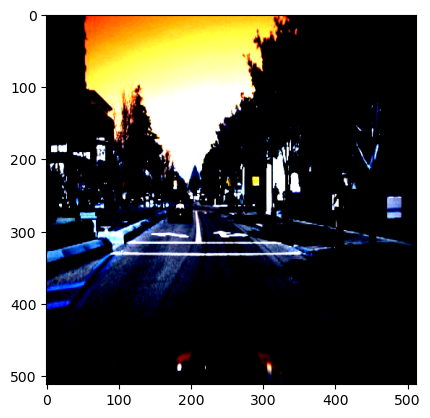

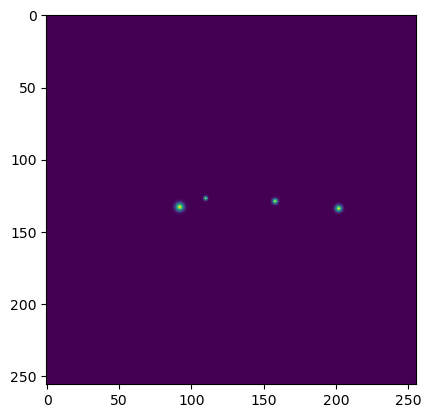

In [19]:
traindataset = CarDataset(train_id, train_df)
valdataset = CarDataset(test_id, train_df)
# Test dataset
img, obj = traindataset[0]
plt.imshow(img.permute(1,2,0))
plt.show()
img.std()
plt.imshow(obj["hmap"].sum(0))

In [20]:
# Pack to dataloaders
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True, num_workers=0)

## Define Centernet model

In [21]:
class Encoder(nn.Module):
    def __init__(self, backbone = 'resnet18'):
        super(Encoder, self).__init__()
        self.backbone = timm.create_model(backbone, pretrained = True)
        self.List = list(self.backbone.children())[:-2]
    def forward(self,X):
        X = X.float()
        for i,layer in enumerate(self.List):
            X = layer(X)
        return X

    
class objdet_Decoder(nn.Module):
    '''series of convs ==> final output heatmap'''
    def __init__(self, n_classes, stride = 2):
        super(objdet_Decoder, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode = 'bilinear')
        self.conv1 = nn.Conv2d(512,256,(3,3),padding = 1)  # 16
        self.conv2 = nn.Conv2d(256,128,(3,3),padding = 1)  #32
        self.conv3 = nn.Conv2d(128,64,(3,3),padding = 1) #64
        self.conv4 = nn.Conv2d(64,32,(3,3),padding = 1) #128
        self.hmap = nn.Conv2d(32,n_classes,(1,1)) #128
        self.regs = nn.Conv2d(32,2,(1,1))
        self.w_h_ = nn.Conv2d(32,2,(1,1))
    def forward(self,X):
        X = self.upsample(X)
        X = F.relu(self.conv1(X))
        X = self.upsample(X)
        X = F.relu(self.conv2(X))
        X = self.upsample(X)
        X = F.relu(self.conv3(X))
        X = self.upsample(X)
        X = F.relu(self.conv4(X))
        return [torch.sigmoid(self.hmap(X)), torch.sigmoid(self.regs(X)), torch.sigmoid(self.w_h_(X))]
    
class centernet(nn.Module):
    def __init__(self, n_classes=n_classes):
        super(centernet, self).__init__()
        self.encoder = Encoder()
        self.obj_decoder = objdet_Decoder(n_classes = n_classes)
        
    def forward(self, X):
        outputs = self.encoder(X)
        detection_maps = self.obj_decoder(outputs)
        return detection_maps

In [22]:
model = centernet()
hm, regr, wh = model(torch.rand(1,3,512,512))
print("Heat Map Shape :",hm.shape)
print("WH Map Shape :",wh.shape)
print("Offset Map Shape :",regr.shape)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Heat Map Shape : torch.Size([1, 5, 256, 256])
WH Map Shape : torch.Size([1, 2, 256, 256])
Offset Map Shape : torch.Size([1, 2, 256, 256])


# Define Loss

In [23]:
class DetectionLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DetectionLoss, self).__init__()
        
    def forward(self,obj, hmap, regs, w_h_):
        hmap_loss = self._neg_loss(hmap, obj['hmap'])
        reg_loss = self.reg_l1_loss(regs,obj['ind_masks'],obj['inds'],obj['regs'])
        w_h_loss = self.reg_l1_loss(w_h_,obj['ind_masks'],obj['inds'],obj['w_h_'])
        loss =  hmap_loss +  0.1*reg_loss +  w_h_loss 
        return loss, hmap_loss, reg_loss, w_h_loss
    
    def _neg_loss(self,pred, gt):
        pos_inds = gt.eq(1).float()
        neg_inds = gt.lt(1).float()

        neg_weights = torch.pow(1 - gt, 4)
        # clamp min value is set to 1e-12 to maintain the numerical stability
        pred = torch.clamp(pred, 1e-12, 1-(1e-12))

        pos_loss = torch.log(pred) * torch.pow(1 - pred, 2) * pos_inds
        neg_loss = torch.log(1 - pred) * torch.pow(pred, 2) * neg_weights * neg_inds

        num_pos = pos_inds.float().sum()
        pos_loss = pos_loss.sum()
        neg_loss = neg_loss.sum()

        if num_pos == 0:
            loss = -neg_loss
        else:
            loss = -(pos_loss + neg_loss) / num_pos
        return loss
    
    def reg_l1_loss(self,regs, mask, ind, gt_regs):
        pred = self.gather_feature(regs, ind, use_transform=True)
        mask = mask.unsqueeze(dim=2).expand_as(pred).float()
        loss = F.l1_loss(pred * mask, gt_regs * mask, reduction='sum')
        loss = loss / (mask.sum() + 1e-4)
        return loss

    def gather_feature(self,feat, ind, mask=None, use_transform=False):
        if use_transform:
            # change a (N, C, H, W) tenor to (N, HxW, C) shape
            batch, channel = feat.shape[:2]
            feat = feat.view(batch, channel, -1).permute((0, 2, 1)).contiguous()

        dim = feat.size(-1)
        ind  = ind.unsqueeze(len(ind.shape)).expand(*ind.shape, dim)
        feat = torch.gather(feat,1,ind)
        if mask is not None:
            mask = mask.unsqueeze(2).expand_as(feat)
            feat = feat[mask]
            feat = feat.reshape(-1, dim)
        return feat

In [24]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# model.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device('cuda')))
# Optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.1,patience=4,verbose=True)
loss_fn = DetectionLoss()

# Train function

In [25]:
def train(epoch):
    model.train()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_mask = 0.0
    running_regr = 0.0
    running_wh = 0.0
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    for idx, (img, obj) in enumerate(t):
        img = img.to(device)
        obj['hmap'], obj['w_h_'], obj['regs'], obj['inds'], obj['ind_masks'] = obj['hmap'].to(device), obj['w_h_'].to(device), obj['regs'].to(device), obj['inds'].to(device), obj['ind_masks'].to(device)
        optimizer.zero_grad()
        # run model
        hmap, regs, wh = model(img)
        loss,mask_loss,regr_loss,wh_loss = loss_fn(obj, hmap, regs, wh)
        
        loss.backward()
        optimizer.step()
        
        # misc
        running_loss += loss.item()
        running_mask += mask_loss.item()
        running_regr += regr_loss.item()
        running_wh += wh_loss.item()
        
        t.set_description(f'(l = {running_loss/(idx+1):.2f})(H = {running_mask/(idx+1):.2f})(R = {running_regr/(idx+1):.2f})(W = {running_wh/(idx+1):.2f})')
        
    #scheduler.step()
    print('train loss : {:.4f}'.format(running_loss/(idx+1)))
    print('maskloss : {:.4f}'.format(running_mask/(idx+1)))
    print('regrloss : {:.4f}'.format(running_regr/(idx+1)))
    print('whloss : {:.4f}'.format(running_wh/(idx+1)))
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                    'loss': running_loss/(idx+1), "mask": running_mask/(idx+1), 
                 "regr": running_regr/(idx+1),
                "wh": running_wh/(idx+1)}
    logs.append(log_epoch)
    scheduler.step(running_loss/(idx+1))

# Train model
To save time, only trained for 5 epochs

In [ ]:
epochs = 100
logs = []
logs_eval = []

if TRAIN:
    for epoch in range(epochs):
        train(epoch)
        torch.save(model,'/workstation/bhanu/CenterNet/models/centernet_model3.pth')
        torch.save(model.state_dict(), '/workstation/bhanu/CenterNet/models/centernet_state_dict3.pth')

# Show predictions

In [ ]:
model.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device(device)))
model.eval()
for id in range(300):
    img, obj = valdataset[id]
    with torch.no_grad():
        hmap, regs, w_h_ = model(img.to(device).float().unsqueeze(0))
    # show image
    img_id = test_id[id]
    image_path = data_dir+str(img_id)
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
#     plt.imshow(hmap.cpu().sum(1)[0])
#     plt.show()
#     plt.imshow(regs.cpu().sum(1)[0])
#     plt.show()
#     plt.imshow(w_h_.cpu().sum(1)[0])
#     plt.show()
    d = showbox(img, hmap.detach(), w_h_.detach(), regs.detach())
    plt.figure()
    fig = plt.imshow(d)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [29]:
model.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device(device)))

<All keys matched successfully>

In [31]:
torch.save(model.state_dict(), 'centernet_state_dict3-2.pth', _use_new_zipfile_serialization=False)